In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
#%gui qt5
#import napari
import scipy.ndimage as ndimage

from read_roi import read_roi_file
from read_roi import read_roi_zip
import skimage
import cv2
from PIL import Image
import glob
import skimage.transform as transform
import os

from torch import nn, optim
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms

In [2]:
threshold = 10
offset = 0.5

data = '/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Classifier/AutoClassifier/'

# Load training data

In [3]:
df = pd.read_csv(data+'MEL_Split_20211101.csv')
df = df[df['Type'].isin(['Chromatoid', 'Secretory', 'Gut'])]
#tdf = df[df['Type'].isin(['Chromatoid', 'Secretory', 'Gut'])]

In [4]:
#df = pd.concat([tdf, df[df['Type']=='Other'].iloc[0:400]])

In [5]:
images = np.array([tifffile.imread(data+'Tiffs/'+a.split('/')[-1]) for a in df['File']])

In [6]:
indices = np.random.choice(images.shape[0],images.shape[0], replace=False)

In [7]:
df['Type'].value_counts()

Gut           434
Chromatoid    220
Secretory     217
Name: Type, dtype: int64

In [8]:
training_images = images[indices[0:int(np.floor(0.8*images.shape[0]))]]
validation_images = images[indices[int(np.floor(0.8*images.shape[0])):]]



In [9]:
labels = np.stack([(df['Type'] == 'Chromatoid').values, (df['Type'] == 'Secretory').values, (df['Type'] == 'Gut').values,
          (df['Type'] == 'Doublet').values, (df['Type'] == 'Junk').values, (df['Type'] == 'Other').values], axis=1)

In [10]:
training_labels = labels[indices[0:int(np.floor(0.8*images.shape[0]))]]
validation_labels = labels[indices[int(np.floor(0.8*images.shape[0])):]]

In [11]:
mean=np.mean(images)
std=np.std(images)






In [12]:
np.save(data+'MeanStd.npy', np.array([mean, std]))

# Augment training data

In [13]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [14]:
def translate_image(image, xshift, yshift):
    translation_matrix = np.float32([ [1,0,xshift], [0,1,yshift] ])
    img_translation = cv2.warpAffine(image, translation_matrix, image.shape[1::-1])
    return img_translation

In [15]:
def rotate_translate_split(inp):
    angle = np.random.randint(0,180)
    xshift = np.random.randint(-20,20)
    yshift = np.random.randint(-20,20)
    destacked = np.reshape(inp, [inp.shape[0]*inp.shape[1], inp.shape[2], inp.shape[3]])
    new_fulls = np.array([np.array(translate_image(rotate_image(f, angle), 
                                                  xshift, yshift)) for f in destacked])
    new_fulls = np.reshape(new_fulls, inp.shape)
    return new_fulls

In [16]:
num_rotations = 12

allimages = np.zeros([num_rotations, training_images.shape[0], training_images.shape[1], training_images.shape[2],
                   training_images.shape[3]])
alllabels = np.zeros([num_rotations, training_labels.shape[0], training_labels.shape[1]])

allimages[0,:] = training_images.copy()
alllabels[0,:] = training_labels.copy()
for i in range(1,num_rotations):
    allimages[i,:] = rotate_translate_split(training_images)
    alllabels[i,:] = training_labels.copy()
    print(i)
allimages = np.reshape(allimages, [allimages.shape[0] * allimages.shape[1], allimages.shape[2], allimages.shape[3], allimages.shape[4]])    
alllabels = np.reshape(alllabels, [alllabels.shape[0] * alllabels.shape[1], alllabels.shape[2]])

1
2
3
4
5
6
7
8
9
10
11


In [17]:
tifffile.imsave(data+'training_rotated.tif', allimages.astype(np.single), imagej=True)
np.save(data+'Labels.npy', alllabels)

tifffile.imsave(data+'validation.tif', validation_images.astype(np.single), imagej=True)
np.save(data+'ValidationLabels.npy', validation_labels)

/scratch/smc/miniconda3/envs/pytorch/lib/python3.7/site-packages/tifffile/tifffile.py:2650: UserWarning: TiffWriter: truncating ImageJ file
  'TiffWriter: truncating ImageJ file', UserWarning


Alternative, does not appear to work for some reason

In [18]:
#raws = tifffile.imread(data+'init_raws.tif').astype(np.single)
#labs = tifffile.imread(data+'init_labs.tif').astype(np.single)

In [19]:
#rotated = np.array([rotate_translate_split(raws,labs) for i in range(0,14)])

In [20]:
#allraws = np.concatenate([raws, rotated[:,0,:,:,:].reshape(rotated.shape[0]*rotated.shape[2], 
#                                     rotated.shape[3], rotated.shape[4], rotated.shape[5])])

In [21]:
#alllabs = np.concatenate([labs, rotated[:,1,:,:,:].reshape(rotated.shape[0]*rotated.shape[2], 
#                                     rotated.shape[3], rotated.shape[4], rotated.shape[5])])

In [22]:
#del rotated

# Load in augmented data, normalize

In [23]:
#raws = tifffile.imread(data+'init_raws.tif')
#labs = tifffile.imread(data+'init_labs.tif')

#mean = np.mean(raws)
#std = np.std(labs)

In [24]:
allimages = tifffile.imread(data+'training_rotated.tif')
alllabels = np.load(data+'Labels.npy')

train_data = allimages
train_truth = alllabels

validation_data = tifffile.imread(data+'validation.tif')
validation_truth = np.load(data+'ValidationLabels.npy')

#mean = np.mean(allraws)
#std = np.std(alllabs)

In [25]:
train_data=(train_data-mean)/(std*1)+offset
validation_data = (validation_data-mean)/(std*1)+offset
#train_truth[np.where(train_truth>threshold)]=1


# Build network

In [26]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        base_scaler=32
        self.conA1 = nn.Conv2d(8,base_scaler,5,stride=1, padding=2)
        self.conA2 = nn.Conv2d(base_scaler, base_scaler, 3, stride=1, padding=1)
        
        self.conB1 = nn.Conv2d(base_scaler, base_scaler*2, 3, stride=1, padding=1)
        self.conB2 = nn.Conv2d(base_scaler*2, base_scaler*2, 3, stride=1, padding=1)
        
        self.conC1 = nn.Conv2d(base_scaler*2, base_scaler*4, 3, stride=1, padding=1)
        self.conC2 = nn.Conv2d(base_scaler*4, base_scaler*4, 3, stride=1, padding=1)

        self.conD1 = nn.Conv2d(base_scaler*4, base_scaler*8, 3, stride=1, padding=1)
        self.conD2 = nn.Conv2d(base_scaler*8, base_scaler*8, 3, stride=1, padding=1)

        self.conE1 = nn.Conv2d(base_scaler*8, base_scaler*16, 3, stride=1, padding=1)
        self.conE2 = nn.Conv2d(base_scaler*16, base_scaler*16,3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(4*32768, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 16)
        self.fc4 = nn.Linear(16, 6)
        
        self.maxpool_noZ = nn.MaxPool2d([2,2])
        self.LReLu = nn.LeakyReLU(0.3)
        
    def forward(self, x):
        self.A = self.LReLu(self.conA2(self.LReLu(self.conA1(x))))
        self.pA = self.maxpool_noZ(self.A)
        
        self.B = self.LReLu(self.conB2(self.LReLu(self.conB1(self.pA))))
        self.pB = self.maxpool_noZ(self.B)
        
        self.C = self.LReLu(self.conC2(self.LReLu(self.conC1(self.pB))))
        self.pC = self.maxpool_noZ(self.C)
        
        self.D = self.LReLu(self.conD2(self.LReLu(self.conD1(self.pC))))
        self.pD = self.maxpool_noZ(self.D)

        self.E = self.LReLu(self.conE2(self.LReLu(self.conE1(self.pD))))
        
        self.Flat = torch.flatten(self.E, 1)
        
        self.Lin1 = self.LReLu(self.fc1(self.Flat))
        self.Lin2 = self.LReLu(self.fc2(self.Lin1))
        self.Lin3 = self.LReLu(self.fc3(self.Lin2))
        self.Lin4 = self.fc4(self.Lin3)
        
        return (self.Lin3)


# Train network

In [30]:
model = UNet()
model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


#from torch.optim import lr_scheduler
#lambdar = lambda epoch: 0.95 ** epoch
#scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambdar)

In [31]:
validation_data.shape

(175, 8, 256, 256)

In [32]:
train_encoded = np.sum(train_truth*np.array([0,1,2,3,4,5]), 1)
validation_encoded = np.sum(validation_truth*np.array([0,1,2,3,4,5]), 1)
for i in range(0,4000):
    idx=np.random.choice(train_data.shape[0], replace=False, size=[80])
    cur_train=torch.from_numpy(train_data[idx,:,:,:]).float().cuda()
    cur_truth=torch.from_numpy(train_encoded[idx]).long().cuda()
    
    results = model(cur_train)
    loss = criterion(results, cur_truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i%100==0):
        with torch.no_grad():
            #valid = model(torch.from_numpy(validation_data).float().cuda()).cpu().numpy()
            valid = np.concatenate([model(torch.from_numpy(validation_data[(i*20):(i*20+20)]).float().cuda()).cpu().numpy() 
                   for i in range(0,int(np.ceil(validation_data.shape[0]/20)))])
            print(i)
            predictions = np.argmax(valid, 1)
            #print(np.sum((predictions-validation_encoded)*(predictions-validation_encoded)))
            print(np.sum(predictions==validation_encoded))
            torch.save(model.state_dict(), data+'PT_weights_'+str(i).zfill(4)+'.pth')
            

0
90
100
95
200
104
300
105
400
123
500
123
600
130
700
133
800
129
900
128
1000
138
1100
142
1200
138
1300
146
1400
140
1500
135
1600
132
1700
143
1800
139
1900
140
2000
134
2100
140
2200
141
2300
130
2400
148
2500
140
2600
137
2700
140
2800
144
2900
139
3000
141
3100
140
3200
140
3300
140
3400
140
3500
140
3600
140
3700
141
3800
140
3900
141


In [56]:
a, b = np.unique(train_encoded, return_counts=True)
b

array([ 172,  172,  340,   44,   69, 1203])

In [51]:
np.sum(predictions==validation_encoded)

327

5.0


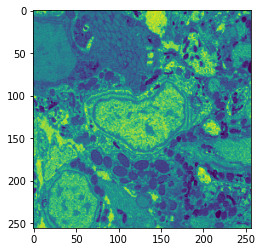

In [44]:
idx = np.random.randint(2000)
plt.imshow(train_data[idx,4,:,:])
print(train_encoded[idx])

Load old weights

# Process a file

In [10]:
model = UNet()
model.cuda()

model.load_state_dict(torch.load(data+'PT_weights_3600.pth'))

<All keys matched successfully>

In [11]:
#raws = tifffile.imread(data+'raws.tif')
#labs = tifffile.imread(data+'labs.tif')

[mean, std, channels] = np.load(data+'MeanStd.npy')

In [12]:
def process_file(fname, model, channel, save_folder):

    
    img = tifffile.imread(fname)
    img = img[np.newaxis,np.newaxis]
    print(img.shape)
    #img = img[0,channel,:,:]
    
    to_process = np.concatenate([(make_windows(a, window_size)) for a in img])
    to_process=(to_process-mean)/(std*1.0)+offset
    #to_process = np.reshape(to_process, [to_process.shape[0]*to_process.shape[1], to_process.shape[2], to_process.shape[3]])
    with torch.no_grad():
        result = np.concatenate([model(torch.from_numpy(to_process[(i*20):(i*20+20)]).float().cuda()).cpu().numpy() 
                           for i in range(0,int(np.ceil(to_process.shape[0]/20)))])
    del to_process
    
    result = np.reshape(result, [img.shape[0], -1, 2, window_size, window_size])
                                 
    
    outputs=np.zeros([img.shape[0], int(channels+2), img.shape[2], img.shape[3]])
    print(outputs.shape)
    outputs[:,0:int(channels),:,:]=img#/np.max(img) * 255.0
    outputs[:,-2,:,:]=np.array([np.round(de_window_xy(a[:,0,:,:], window_size, img.shape[2:4])*255.0) for a in result])
    outputs[:,-1,:,:]=np.array([np.round(de_window_xy(a[:,1,:,:], window_size, img.shape[2:4])*255.0) for a in result])
    
    outputs = np.where(outputs<0, 0, outputs)
    
    f = fname.split('/')[-1]
    tifffile.imsave(save_folder+f[0:-4]+'.tif', outputs.astype(np.ubyte), imagej=True)
    return outputs

In [44]:
for f in glob.glob('/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/*.tif'):
    print(f)
    process_file(f, model, 0, '/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Output/')


/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0284.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0956.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0301.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1052.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/T

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0291.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0501.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0034.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1587.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0668.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0568.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0192.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0702.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0556.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0069.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0322.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0694.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1278.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0233.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0073.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1179.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1100.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0032.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0304.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0941.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1126.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1146.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1620.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0858.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0472.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0708.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1486.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0801.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0895.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0296.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0595.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1292.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1105.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0347.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1215.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0421.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0722.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0849.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0609.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1015.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0761.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0413.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0249.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1070.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1240.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0075.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0597.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0882.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0250.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0859.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0372.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0306.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0618.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0658.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0456.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1004.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0638.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0317.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1360.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0969.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1007.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0783.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1276.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0796.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1609.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1627.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0603.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0133.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0695.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0066.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0350.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1084.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1003.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1629.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1636.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0845.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0138.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1469.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0705.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0256.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0426.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1034.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1031.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0842.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1493.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0061.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1226.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0427.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1256.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0630.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0101.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0672.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1192.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0058.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1503.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1106.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1319.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0745.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0666.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1415.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0220.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0015.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0050.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0354.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1205.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0823.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1588.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0485.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1175.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1675.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0780.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0743.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1242.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0197.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1423.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1023.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0834.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1199.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0025.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1510.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0601.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1411.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1345.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0029.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0528.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0687.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0048.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1051.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1189.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0678.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1127.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0562.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0797.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0277.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0868.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0542.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0017.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0704.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1698.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0355.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1218.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1374.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0353.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1329.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1601.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0864.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0966.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0582.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0470.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0817.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1161.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1436.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1409.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0559.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0172.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0596.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0680.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0647.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0247.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1612.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0023.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0385.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0430.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1395.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0129.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0779.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1198.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0173.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1014.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0901.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1621.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1634.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1602.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0812.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed1461.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_crash/cjw/DeepLearn/Tiffs/stack_ali_translation_bin4_normed0637.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210721_MER_IMARE-106746_20_15_1A_control/20-15-1A_after_cr

In [13]:
for f in glob.glob('/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/*.tif'):
    print(f)
    process_file(f, model, 0, '/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Output/')


/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0500.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1473.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0691.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1199.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1478.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0957.tif


(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0560.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0121.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0108.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0380.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1404.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1636.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1043.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0498.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1559.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1106.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0575.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0686.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1120.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0062.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1550.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1555.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0049.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0234.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0629.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1085.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0222.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1238.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0317.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1040.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1393.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0664.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1249.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0390.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0185.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0132.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0975.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0879.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1627.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0179.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1641.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0038.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0870.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1343.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1245.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0397.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0512.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1063.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1326.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1613.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0263.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1684.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1472.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1642.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0976.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0704.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1321.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0655.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0079.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0359.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0452.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1428.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0583.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1264.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0576.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1313.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0316.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0609.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0166.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0020.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1394.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0076.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0106.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0792.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0730.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0445.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1692.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0180.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0491.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1589.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0777.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0977.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0484.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1204.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0218.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1653.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0746.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0822.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1668.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1225.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0004.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0313.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0233.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1293.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0478.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0130.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0277.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0930.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0402.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1143.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0345.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1597.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0266.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1454.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0545.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0068.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1316.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0446.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0454.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1516.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0240.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0675.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1650.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0006.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0732.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0669.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0882.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0115.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1227.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0813.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1689.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0405.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1601.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0353.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0015.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1236.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0770.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0010.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0310.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1273.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0199.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0623.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0530.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0065.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0805.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1661.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0374.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0039.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0489.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0511.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1342.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1614.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1306.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0959.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0274.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0513.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1304.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0661.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1552.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0683.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0442.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0417.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0847.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0502.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0685.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0563.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0986.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0639.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0912.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1267.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0118.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0043.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0924.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1520.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0267.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1417.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0383.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1571.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1645.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0745.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0058.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1647.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0956.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1573.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0189.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0183.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0631.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0789.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed1080.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0780.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_fiji_normed0816.tif
(1, 1, 3360, 3024)
(1, 3, 3360, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210909_MER_20-15-5B_4dpi/cjw/DeepLearn/Tiffs/stack_ali_bin4_f

In [14]:
for f in glob.glob('/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/*.tif'):
    print(f)
    process_file(f, model, 0, '/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Output/')


/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0431.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0043.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0999.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1265.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1181.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_nor

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0880.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0976.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0668.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1307.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0454.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0187.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1159.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0919.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0697.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1097.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1183.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1032.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0027.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1293.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0312.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1311.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1117.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0559.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1185.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0952.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0705.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0236.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0326.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1003.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1277.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0087.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1240.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1403.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0079.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0430.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1465.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0961.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0622.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1160.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1101.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0219.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0200.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0297.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0403.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1411.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0558.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1459.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1367.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1281.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1286.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0967.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1088.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1013.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1239.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1157.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0586.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1295.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0748.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0457.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0075.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0456.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0030.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1039.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1473.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1004.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0399.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1394.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0685.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0150.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0051.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0176.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0607.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0305.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0923.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0722.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0933.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0047.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0251.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0001.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1096.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0344.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0016.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1273.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1187.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0899.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0034.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0858.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1059.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0927.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0544.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0733.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0782.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0019.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1079.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0680.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0376.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1462.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0598.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1047.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1049.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0494.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0945.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0177.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0343.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1373.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0379.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0708.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0517.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0102.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1300.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0316.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0767.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0709.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1043.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1448.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0552.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0411.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0683.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0039.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1363.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0062.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1364.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1146.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1279.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0902.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1022.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1090.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1008.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0929.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0859.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1010.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0097.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0529.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0750.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0347.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1140.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1152.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0965.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0515.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1150.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1463.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0276.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0499.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0110.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0803.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1433.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0049.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0805.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1120.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1127.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0718.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0922.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0530.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0212.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0970.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1243.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0640.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0321.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1061.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0678.tif
(1, 1, 2156, 2925)
(1, 3, 2156, 2925)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210129_MER_20-15-7b_8dpi_stack2/cjw/DeepLearn/Tiffs

In [15]:
for f in glob.glob('/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/*.tif'):
    print(f)
    process_file(f, model, 0, '/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Output/')


/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0431.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0043.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0999.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1265.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1181.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1179.tif
(1, 1, 2261, 3024)
(1, 3

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0950.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1604.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0682.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0279.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0880.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0976.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0672.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1285.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0033.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1635.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0472.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1506.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1306.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1098.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1644.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0531.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0127.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0693.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0885.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1275.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0170.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1631.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0214.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0670.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1392.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0155.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1214.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1390.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1571.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0235.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0296.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0978.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1632.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0939.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1123.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1162.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0180.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0605.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0884.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0920.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0099.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0669.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0152.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1100.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0500.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0689.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1124.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0648.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0023.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0151.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0612.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1002.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0900.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0736.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1142.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0295.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0986.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1466.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1353.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0085.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0610.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1063.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1625.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0747.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0288.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0710.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1119.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1573.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0575.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1297.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0044.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1019.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1525.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0260.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0775.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0777.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1089.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1383.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0309.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0207.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0382.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0557.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0233.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0528.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0173.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1288.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0667.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1218.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1269.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1216.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1106.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1545.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0068.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1547.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0073.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0845.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0690.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0083.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1642.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1509.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0013.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1189.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0927.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0544.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0647.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0119.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1267.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0663.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0733.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0782.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0019.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1503.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1079.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1599.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0046.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0715.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0345.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0376.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1462.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0598.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1287.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0769.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1515.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0749.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0741.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1616.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0994.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1180.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1372.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0634.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0940.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0331.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0202.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1456.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1256.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0548.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0676.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0694.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1512.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1617.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1029.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1488.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0132.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0602.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1131.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1533.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1305.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1543.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0178.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0447.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0037.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0249.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0167.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0129.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1650.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0593.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1232.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1313.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0590.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0881.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0115.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1055.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1208.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0589.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0336.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1116.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1077.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0459.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1144.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1073.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1378.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1312.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0823.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1477.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1000.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1523.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0946.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0072.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0330.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0469.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0294.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0052.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1605.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1318.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0512.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1558.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0970.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0957.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1284.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1627.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0427.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1344.tif
(1, 1

(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1061.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0678.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0822.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1078.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed0954.tif
(1, 1, 2261, 3024)
(1, 3, 2261, 3024)
/n/core/micro/asa/stn/mel/20-15_Irradiation_Datasets/20210326_MER_20-15-8a_14dpi/cjw/DeepLearn/Tiffs/whole_ali_bin4_normed1649.tif
(1, 1